In [1]:
import random
import numpy as np
from model import Model_3DCNN, strip_prefix_if_present
from data_reader import Dataset_MLHDF
from img_util import GaussianFilter, Voxelizer3D
from file_util import *
import torch
import torch.nn as nn

from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch.optim import Adam, RMSprop, lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Dataset_MLHDF('../../data/processed/pdbbind2016_general_train.hdf', 1, '../../data/processed/general_train_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=2)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=1)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

/home/vscode/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
device = torch.device("cpu")
vol_batch = torch.zeros((50,19,48,48,48)).float().to(device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)

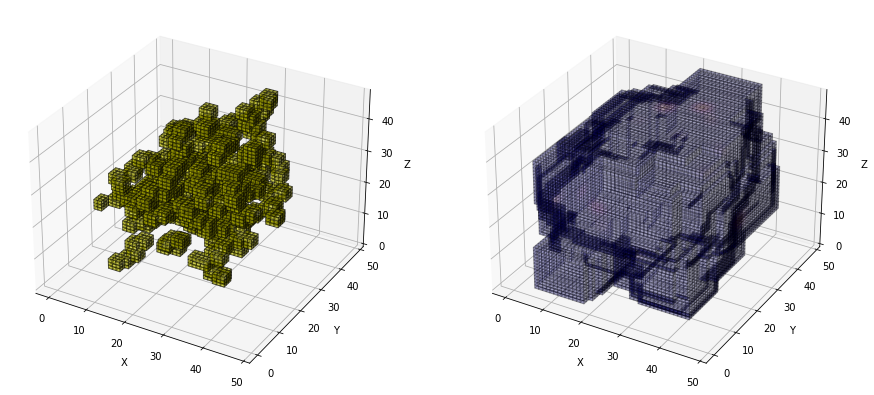

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

d2 = vol_batch_gaus[0][1].numpy()
d = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.voxels(d,facecolors='yellow', alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Quantum encoding

We etrieve blocks of (2x2x2) from the image and encode them in a quantum circuit. We explore different techniques of data encoding.

We first scale the image to the $[0, \pi/2]$ range

In [5]:
from sklearn.preprocessing import MinMaxScaler
# Data
d = vol_batch_gaus[0][1].numpy()
size = d.shape[0]
# Scaler
scaler = MinMaxScaler((0, np.pi/2))
d_scaled = scaler.fit_transform(d.reshape(-1, 1)).reshape(size,size,size)

In [6]:
# Rolling 3D window for ND array
def roll(a,      # ND array
         b,      # rolling 2D window array
         dx=1,   # horizontal step, abscissa, number of columns
         dy=1,   # vertical step, ordinate, number of rows
         dz=1):  # transverse step, applicate, number of layers
    shape = a.shape[:-3] + \
            ((a.shape[-3] - b.shape[-3]) // dz + 1,) + \
            ((a.shape[-2] - b.shape[-2]) // dy + 1,) + \
            ((a.shape[-1] - b.shape[-1]) // dx + 1,) + \
            b.shape  # multidimensional "sausage" with 3D cross-section
    strides = a.strides[:-3] + \
              (a.strides[-3] * dz,) + \
              (a.strides[-2] * dy,) + \
              (a.strides[-1] * dx,) + \
              a.strides[-3:]
    print('shape =', shape, " strides =", strides)  # for debugging
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

b=np.zeros((2,2,2))
windows = roll(d_scaled,b,dx=2,dy=2,dz=2).reshape(-1,2,2,2)
windows.shape

shape = (24, 24, 24, 2, 2, 2)  strides = (18432, 384, 8, 9216, 192, 4)


(13824, 2, 2, 2)

In [96]:
import qiskit 
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister
from qiskit import BasicAer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.quantum_info import Statevector

Get the (2,2,2) boxel as an example (with non-zero entries).

In [22]:
for i in range(windows.shape[0]):
    if (windows[i]>1).all():
        print(i)
box = windows[3251]  
print(box)

3251
3252
4910
6974
9564
10071
10140
10647
11172
[[[1.2239136 1.4087601]
  [1.1057807 1.317533 ]]

 [[1.108935  1.3337419]
  [1.1039283 1.4073423]]]


Design quantum circuit

0 0 0 0 : 0.1201968165638691
0 0 0 1 : 0.33249469666138126
1 0 0 0 : 0.1575487656336485
1 0 0 1 : 0.316509703573503
0 1 0 0 : 0.15854633939105284
0 1 0 1 : 0.3160111695758919
1 1 0 0 : 0.15913144301550533
1 1 0 1 : 0.31571694242643733
0 0 1 0 : 0.05703810453813428
0 0 1 1 : 0.34892212629150265
1 0 1 0 : 0.08302863829030932
1 0 1 1 : 0.34366588744658777
0 1 1 0 : 0.08858793404944178
0 1 1 1 : 0.3422749992988798
1 1 1 0 : 0.05753273468390206
1 1 1 1 : 0.3488409093144222


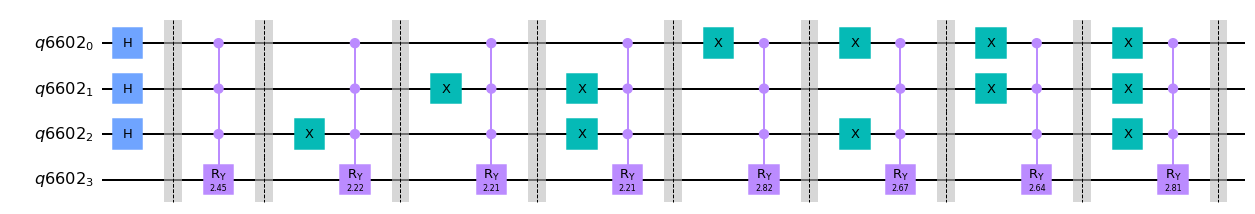

In [157]:
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)
# Apply hadamard gates on qubits 0,1,2
qc.h(0)
qc.h(1)
qc.h(2)
qc.barrier()

coefs = []
for k in range(box.shape[0]):
    for j in range(box.shape[1]):
        for i in range(box.shape[2]):
            theta = box[i,j,k]
            print(i,j,k,0, ':', np.cos(theta)/np.sqrt(8)  )
            print(i,j,k,1, ':', np.sin(theta)/np.sqrt(8) )
            coefs.append(np.cos(theta)/np.sqrt(8))
            coefs.append(np.sin(theta)/np.sqrt(8))
            # i-> 2, j->1, k->0, theta->3
            # Apply X gate if the qubit is 1
            if(i==1):
                qc.x(2)
            if(j==1):
                qc.x(1)
            if(k==1):
                qc.x(0)    
            
            # Define triple controlled Rr
            cccry = RYGate(2*theta).control(3)
            # Apply triple controlled Ry rotation on qubit 3 
            qc.append(cccry, [0, 1,2, 3])
            qc.barrier()

# Draw circuit
qc.draw('mpl')

In [158]:
backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)
Statevector(qc_state).to_dict()

{'0000': (0.08858792800124993+8.354670182621102e-16j),
 '0001': (0.15854633358666753+1.6927308042831002e-15j),
 '0010': (0.3535533905932747+3.833777754345913e-15j),
 '0011': (-0.2706593437615528-3.6874312325117424e-15j),
 '0100': (0.3535533905932741+3.4469586888086e-15j),
 '0101': (0.35355339059327395+3.8327920782554334e-15j),
 '0110': (0.0570381046742952+5.476407569435673e-16j),
 '0111': (-0.293073533549566-4.303773145980577e-15j),
 '1000': (0.34227500494842733+3.9017314379976006e-15j),
 '1001': (0.31601117085670466+4.775988751781408e-15j),
 '1011': (0.22747201945418657+3.100724204904417e-15j),
 '1110': (0.3489221325957475+4.511148196137475e-15j),
 '1111': (-0.19775718427599975-2.5393969591624494e-15j)}

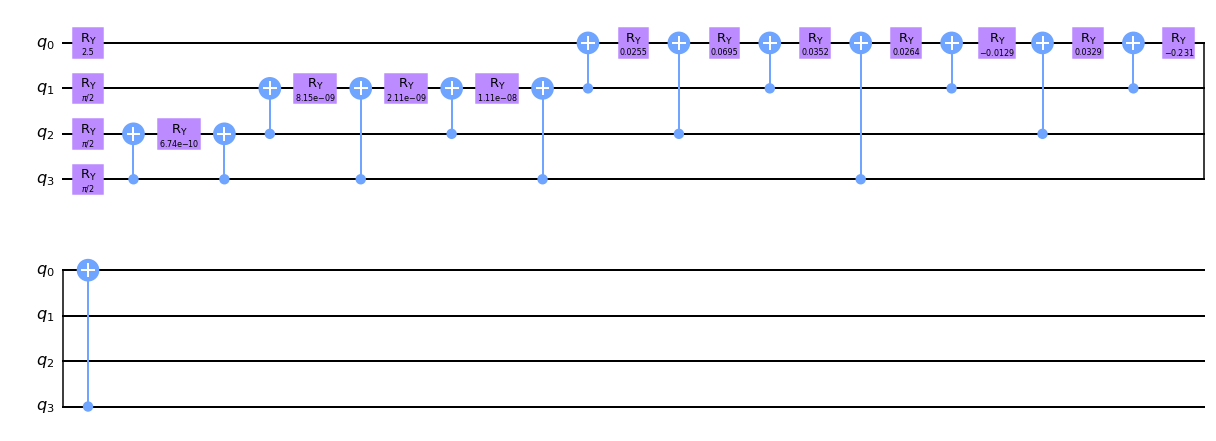

In [161]:
initial_state=  coefs/np.sqrt(np.sum(np.square(coefs)))
qc2 = QuantumCircuit(4)
qc2.initialize(initial_state, list(range(4)))
qc2 = transpile(qc2, basis_gates = ['cx', 'cry', 'h', 'ry', 'barrier'])
qc2.draw('mpl')



In [163]:
backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc2, backend))
qc_state = job.result().get_statevector(qc2)
Statevector(qc_state).to_dict()

{'0000': (0.12019681690746228+1.3448387053906368e-17j),
 '0001': (0.3324946976118465+1.6616173061491385e-16j),
 '0010': (0.15754876608401547+3.277242722947664e-17j),
 '0011': (0.31650970447827376+7.558148947850697e-17j),
 '0100': (0.1585463398442715+3.578997273823595e-17j),
 '0101': (0.31601117047923766+7.611899585447254e-17j),
 '0110': (0.15913144347039654+1.573273246722889e-17j),
 '0111': (0.315716943328942+1.6017637963918962e-16j),
 '1000': (0.0570381047011827+4.1285905990864387e-17j),
 '1001': (0.34892212728892696+3.6826697322130934e-18j),
 '1010': (0.08302863852765394+1.4635017492930736e-17j),
 '1011': (0.34366588842898677+8.191792768774077e-17j),
 '1100': (0.08858793430267822+1.856354369178144e-17j),
 '1101': (0.34227500027730284+8.279566955287356e-17j),
 '1110': (0.05753273484836437+4.4145734252861607e-17j),
 '1111': (0.34884091031161446+4.813942475969117e-18j)}

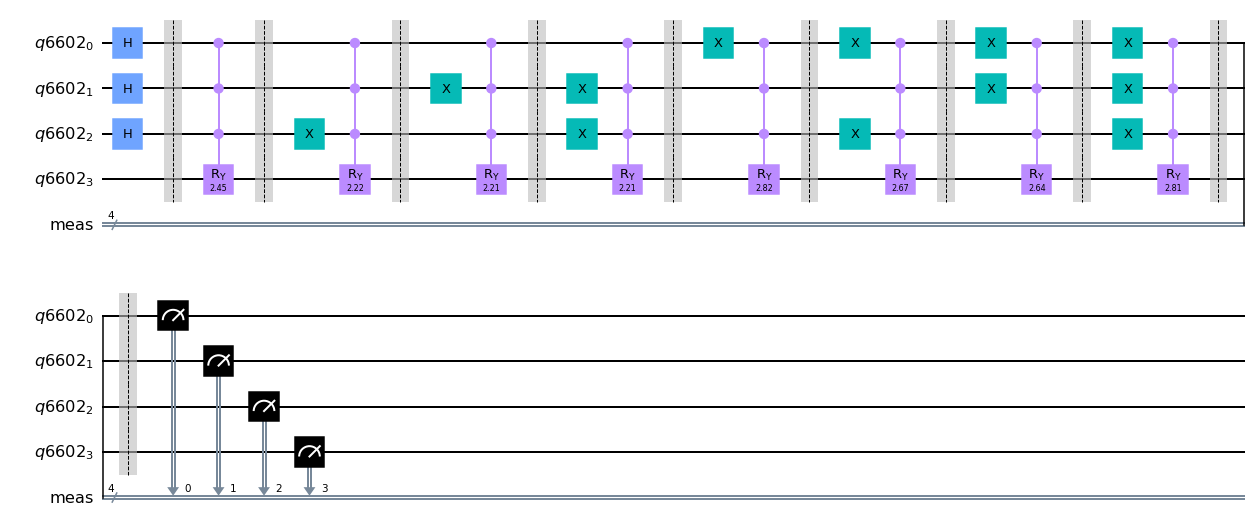

In [160]:
# Measure all qubits
qc.measure_all()
# Draw circuit
qc.draw('mpl')

{'0110': 56, '0100': 686, '1100': 269, '1000': 298, '0001': 1016, '1111': 876, '0010': 1009, '0000': 739, '1110': 994, '0101': 1050, '0111': 160, '0011': 766, '1011': 273}


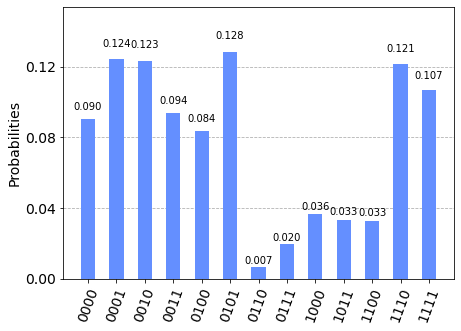

In [105]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=4096*2)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Running on real device

In [87]:
IBMQ.ibmq.save_account('14da2122927818ae07333f8f88f89b5c8505f0ed38432530caeeda7fa5b50fc69fe61230afe3b56e8d984ce87d9c1575bcb2d3987be794ac60ee97e2d9b220f8', overwrite=True)

IBMQ.ibmq.load_account()

provider = IBMQ.get_provider(hub = 'ibm-q')

print([backend.name() for backend in IBMQ.providers()[0].backends()])

ibmqfactory.load_account:WARNING:2022-07-13 09:56:27,301: Credentials are already in use. The existing account in the session will be replaced.


['ibmq_qasm_simulator', 'ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'simulator_statevector', 'simulator_mps', 'simulator_extended_stabilizer', 'simulator_stabilizer', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']


In [88]:
# Choose IBM backend
device = provider.get_backend('ibmq_lima')

{'0000': 358, '0001': 363, '0010': 268, '0011': 299, '0100': 280, '0101': 256, '0110': 252, '0111': 266, '1000': 249, '1001': 220, '1010': 204, '1011': 228, '1100': 243, '1101': 199, '1110': 189, '1111': 222}


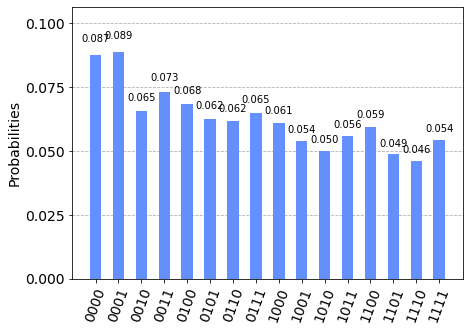

In [89]:
t_qc2 = transpile(qc, device, optimization_level=3)
result2 = device.run(t_qc2, shots=4096).result()
counts2 = result2.get_counts(qc)
print(counts2)
plot_histogram(counts2)